In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [43]:
class SteepestDescentWolfe:
    def __init__(self):
        pass
    
    def optimize(self, 
                 func,  
                 x0, 
                 max_iterations=1000,
                 h=1e-5,
                 stop_value=None,
                 tolerance=1e-8,
                 c1=1e-4,
                 c2=0.9):
        """
        Steepest Descent with Wolfe line search
        
        Parameters:
        - func: objective function to minimize
        - x0: initial point
        - max_iterations: maximum number of iterations
        - h: step size for numerical gradient
        - stop_value: stop if function value reaches this threshold
        - tolerance: gradient norm tolerance for convergence
        - c1, c2: Wolfe conditions parameters
        """
        
        x = np.array(x0, dtype=float)
        trajectory = []
        
        for iteration in range(max_iterations):
            f_val = func(x)
            trajectory.append(f_val)

            # Check stopping criteria
            if stop_value and f_val <= stop_value:
                print(f"Stopping criterion reached at iteration {iteration}")
                break

            grad = self.numerical_gradient(func, x, h=h)
            # Search direction is negative gradient
            p = -grad
            
            # Line search with Wolfe conditions
            alpha = self.wolfe_line_search(func, x, p, grad, c1=c1, c2=c2, h=h)
            
            # Update position
            x = x + alpha * p
            
        return x, trajectory
    
    def numerical_gradient(self, f, x, h):
        """
        Compute numerical gradient using central differences
        """
        n = len(x)
        grad = np.zeros(n)
        
        for i in range(n):
            x_plus = x.copy()
            x_minus = x.copy()
            
            x_plus[i] += h
            x_minus[i] -= h
            
            grad[i] = (f(x_plus) - f(x_minus)) / (2*h)

        return grad
    
    def wolfe_line_search(self, func, x, p, grad, c1=1e-4, c2=0.9, h=1e-5, alpha_init=1.0, max_iter=50):
        """
        Line search satisfying Wolfe conditions
        """
        alpha = alpha_init
        f_x = func(x)
        grad_p = np.dot(grad, p)
        
        # If search direction is not descent direction, return small step
        if grad_p >= 0:
            return 1e-8
        
        for i in range(max_iter):
            x_new = x + alpha * p
            f_new = func(x_new)
            
            # Armijo condition (sufficient decrease)
            armijo_condition = f_new <= f_x + c1 * alpha * grad_p
            
            if armijo_condition:
                # Compute gradient at new point for curvature condition
                grad_new = self.numerical_gradient(func, x_new, h=h)
                grad_new_p = np.dot(grad_new, p)
                
                # Curvature condition (Wolfe condition)
                curvature_condition = grad_new_p >= c2 * grad_p
                
                if curvature_condition:
                    return alpha
                else:
                    # Increase step size if curvature condition not met
                    alpha *= 2.0
            else:
                # Decrease step size if Armijo condition not met
                alpha *= 0.5
                
            # Prevent step size from becoming too small
            if alpha < 1e-10:
                return 1e-10
                
        return alpha
    
    def plot(self, trajectory, title="Steepest Descent"):
        plt.figure(figsize=(8, 6))
        plt.plot(trajectory)
        plt.title(title)
        plt.xlabel('Iteraciones')
        plt.ylabel('Valor de la función')
        plt.grid(True)
        plt.show()

In [36]:
class BFGS:
    def __init__(self):
        pass
    
    def optimize(self, 
                 func,  
                 x0, 
                 max_iterations=1000,
                 h=1e-5,
                 stop_value=None,
                 c1=1e-4,
                 c2=0.9):
        """
        BFGS optimization algorithm with Wolfe conditions for line search
        
        Parameters:
        - func: objective function to minimize
        - x0: initial point
        - max_iterations: maximum number of iterations
        - h: step size for numerical gradient
        - stop_value: stop if function value reaches this threshold
        - c1: Armijo condition parameter (sufficient decrease)
        - c2: curvature condition parameter
        """
        
        x = np.array(x0, dtype=float)
        n = len(x)
        H_inv = np.eye(n)  # Initial inverse Hessian approximation
        trajectory = []
        
        for iteration in range(max_iterations):
            f_val = func(x)
            trajectory.append(f_val)

            # Check stopping criteria
            if stop_value and f_val <= stop_value:
                print(f"Stopping criterion reached at iteration {iteration}")
                break

            grad = self.numerical_gradient(func, x, h=h)

            # Compute search direction
            p = -H_inv @ grad 

            # Line search with Wolfe conditions
            alpha = self.wolfe_line_search(func, x, p, grad, c1=c1, c2=c2, h=h)
            
            # Update position
            x_new = x + alpha * p
            grad_new = self.numerical_gradient(func, x_new, h=h)

            # BFGS update vectors
            s = x_new - x
            y = grad_new - grad

            # Update inverse Hessian approximation (BFGS formula)
            if np.dot(y, s) > 1e-10:  # Ensure positive definiteness
                rho = 1.0 / np.dot(y, s)
                I = np.eye(n)
                H_inv = (I - rho * np.outer(s, y)) @ H_inv @ (I - rho * np.outer(y, s)) + rho * np.outer(s, s)

            x = x_new
            
        return x, trajectory
    
    def wolfe_line_search(self, func, x, p, grad, c1=1e-4, c2=0.9, h=1e-5, alpha_init=1.0, max_iter=50):
        """
        Line search satisfying Wolfe conditions
        
        Parameters:
        - func: objective function
        - x: current point
        - p: search direction
        - grad: gradient at current point
        - c1: Armijo condition parameter
        - c2: curvature condition parameter
        - h: step size for numerical gradient
        - alpha_init: initial step size
        - max_iter: maximum line search iterations
        """
        alpha = alpha_init
        f_x = func(x)
        grad_p = np.dot(grad, p)
        
        # If search direction is not descent direction, return small step
        if grad_p >= 0:
            return 1e-8
        
        for i in range(max_iter):
            x_new = x + alpha * p
            f_new = func(x_new)
            
            # Armijo condition (sufficient decrease)
            armijo_condition = f_new <= f_x + c1 * alpha * grad_p
            
            if armijo_condition:
                # Compute gradient at new point for curvature condition
                grad_new = self.numerical_gradient(func, x_new, h=h)
                grad_new_p = np.dot(grad_new, p)
                
                # Curvature condition (Wolfe condition)
                curvature_condition = grad_new_p >= c2 * grad_p
                
                if curvature_condition:
                    return alpha
                else:
                    # Increase step size if curvature condition not met
                    alpha *= 2.0
            else:
                # Decrease step size if Armijo condition not met
                alpha *= 0.5
                
            # Prevent step size from becoming too small
            if alpha < 1e-10:
                return 1e-10
                
        return alpha
    
    def numerical_gradient(self, f, x, h):
        """
        Compute numerical gradient using central differences
        """
        n = len(x)
        grad = np.zeros(n)
        
        for i in range(n):
            x_plus = x.copy()
            x_minus = x.copy()
            
            x_plus[i] += h
            x_minus[i] -= h
            
            grad[i] = (f(x_plus) - f(x_minus)) / (2*h)

        return grad

    def plot(self, trajectory, title="BFGS"):
        plt.figure(figsize=(8, 6))
        plt.plot(trajectory)
        plt.title(title)
        plt.xlabel('Iteraciones')
        plt.ylabel('Valor de la función')
        plt.grid(True)
        plt.show()

In [37]:
class Newton:
    def __init__(self):
        pass
    
    def optimize(self, 
                 func,  
                 x0, 
                 max_iterations=1000,
                 h=1e-5,
                 stop_value=None,
                 tolerance=1e-8,
                 c1=1e-4,
                 c2=0.9):
        """
        Newton's method for optimization with line search
        
        Parameters:
        - func: objective function to minimize
        - x0: initial point
        - max_iterations: maximum number of iterations
        - h: step size for numerical derivatives
        - stop_value: stop if function value reaches this threshold
        - tolerance: gradient norm tolerance for convergence
        - c1, c2: Wolfe conditions parameters
        """
        
        x = np.array(x0, dtype=float)
        n = len(x)
        trajectory = []
        
        for iteration in range(max_iterations):
            f_val = func(x)
            trajectory.append(f_val)

            # Check stopping criteria
            if stop_value and f_val <= stop_value:
                print(f"Stopping criterion reached at iteration {iteration}")
                break

            grad = self.numerical_gradient(func, x, h=h)
            grad_norm = np.linalg.norm(grad)
            
            # Check gradient convergence
            if grad_norm < tolerance:
                print(f"Gradient convergence achieved at iteration {iteration}")
                break

            # Compute Hessian matrix
            hessian = self.numerical_hessian(func, x, h=h)
            
            try:
                # Solve Newton system: H * p = -grad
                p = np.linalg.solve(hessian, -grad)
            except np.linalg.LinAlgError:
                # If Hessian is singular, use regularization
                print(f"Singular Hessian at iteration {iteration}, using regularization")
                regularization = 1e-6 * np.eye(n)
                p = np.linalg.solve(hessian + regularization, -grad)
            
            # Check if direction is descent direction
            if np.dot(grad, p) >= 0:
                print(f"Not a descent direction at iteration {iteration}, using negative gradient")
                p = -grad
            
            # Line search with Wolfe conditions
            alpha = self.wolfe_line_search(func, x, p, grad, c1=c1, c2=c2, h=h)
            
            # Update position
            x = x + alpha * p
            
        return x, trajectory
    
    def numerical_gradient(self, f, x, h):
        """
        Compute numerical gradient using central differences
        """
        n = len(x)
        grad = np.zeros(n)
        
        for i in range(n):
            x_plus = x.copy()
            x_minus = x.copy()
            
            x_plus[i] += h
            x_minus[i] -= h
            
            grad[i] = (f(x_plus) - f(x_minus)) / (2*h)

        return grad
    
    def numerical_hessian(self, f, x, h):
        """
        Compute numerical Hessian using central differences
        """
        n = len(x)
        hessian = np.zeros((n, n))
        
        # Diagonal elements
        for i in range(n):
            x_plus = x.copy()
            x_minus = x.copy()
            x_plus[i] += h
            x_minus[i] -= h
            
            hessian[i, i] = (f(x_plus) - 2*f(x) + f(x_minus)) / (h**2)
        
        # Off-diagonal elements
        for i in range(n):
            for j in range(i+1, n):
                x_pp = x.copy()
                x_pm = x.copy()
                x_mp = x.copy()
                x_mm = x.copy()
                
                x_pp[i] += h
                x_pp[j] += h
                
                x_pm[i] += h
                x_pm[j] -= h
                
                x_mp[i] -= h
                x_mp[j] += h
                
                x_mm[i] -= h
                x_mm[j] -= h
                
                hessian[i, j] = (f(x_pp) - f(x_pm) - f(x_mp) + f(x_mm)) / (4 * h**2)
                hessian[j, i] = hessian[i, j]  # Symmetry
        
        return hessian
    
    def wolfe_line_search(self, func, x, p, grad, c1=1e-4, c2=0.9, h=1e-5, alpha_init=1.0, max_iter=50):
        """
        Line search satisfying Wolfe conditions
        """
        alpha = alpha_init
        f_x = func(x)
        grad_p = np.dot(grad, p)
        
        # If search direction is not descent direction, return small step
        if grad_p >= 0:
            return 1e-8
        
        for i in range(max_iter):
            x_new = x + alpha * p
            f_new = func(x_new)
            
            # Armijo condition (sufficient decrease)
            armijo_condition = f_new <= f_x + c1 * alpha * grad_p
            
            if armijo_condition:
                # Compute gradient at new point for curvature condition
                grad_new = self.numerical_gradient(func, x_new, h=h)
                grad_new_p = np.dot(grad_new, p)
                
                # Curvature condition (Wolfe condition)
                curvature_condition = grad_new_p >= c2 * grad_p
                
                if curvature_condition:
                    return alpha
                else:
                    # Increase step size if curvature condition not met
                    alpha *= 2.0
            else:
                # Decrease step size if Armijo condition not met
                alpha *= 0.5
                
            # Prevent step size from becoming too small
            if alpha < 1e-10:
                return 1e-10
                
        return alpha
    
    def plot(self, trajectory, title="Newton"):
        plt.figure(figsize=(8, 6))
        plt.plot(trajectory)
        plt.title(title)
        plt.xlabel('Iteraciones')
        plt.ylabel('Valor de la función')
        plt.grid(True)
        plt.show()

In [38]:
# (5)
def rosenbrock(x):
    result = 0
    for i in range(len(x) - 1):
        result += 100 * (x[i+1] - x[i]**2)**2 + (1 - x[i])**2
    return result

In [39]:
# Valores de prueba
# x0 = [0.5, 0.5, 0.5, 0.5, 0.5]
n = 5
x0 = [0.5] * n

# algorithms instances
sd_algorithm = SteepestDescentWolfe()
bfgs_algorithm = BFGS()
newton_algorithm = Newton()

# store results for comparison
x_values = []
trajectories = []
function_values = []

FUNCIÓN ROSENBROCK
Valor óptimo encontrado: [0.98163202 0.9637258  0.92834617 0.8616938  0.74166391]
Valor de la función en el óptimo: 0.02600977389485091
Número de iteraciones: 1000

Gráfica Descenso de la función:


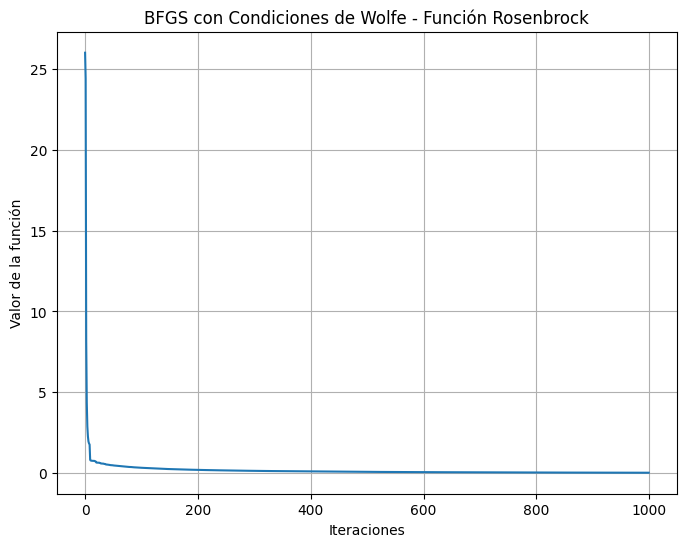

In [40]:
x_rosenbrock, trajectory_rosenbrock = sd_algorithm.optimize(
    func=rosenbrock,
    x0=x0,
    h=1e-5,
    max_iterations=1000,
    stop_value=1e-2
)
x_values.append(x_rosenbrock)
trajectories.append(trajectory_rosenbrock)
function_values.append(rosenbrock(x_rosenbrock))

print("="*60)
print("FUNCIÓN ROSENBROCK")
print("="*60)
print("Valor óptimo encontrado:", x_rosenbrock)
print("Valor de la función en el óptimo:", rosenbrock(x_rosenbrock))
print("Número de iteraciones:", len(trajectory_rosenbrock))
print("\nGráfica Descenso de la función:")
sd_algorithm.plot(trajectory=trajectory_rosenbrock, title="BFGS con Condiciones de Wolfe - Función Rosenbrock")

Stopping criterion reached at iteration 19
FUNCIÓN ROSENBROCK
Valor óptimo encontrado: [0.99258955 0.98507864 0.97017093 0.94051482 0.88124634]
Valor de la función en el óptimo: 0.005867406182907281
Número de iteraciones: 20

Gráfica Descenso de la función:


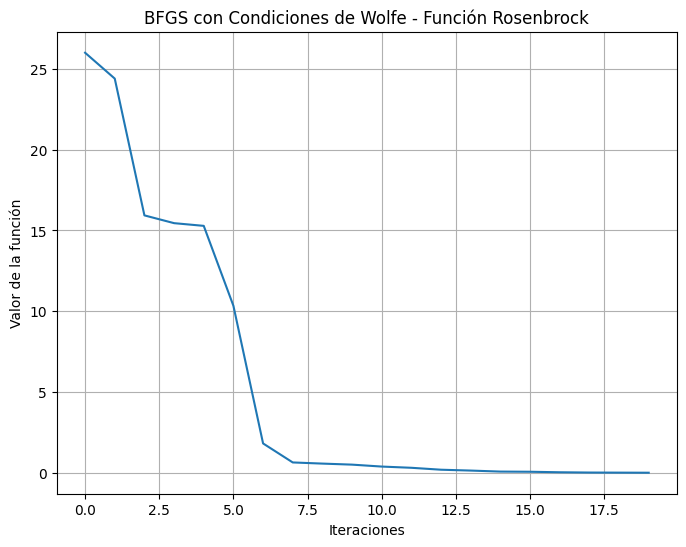

In [41]:
x_rosenbrock, trajectory_rosenbrock = bfgs_algorithm.optimize(
    func=rosenbrock,
    x0=x0,
    h=1e-5,
    max_iterations=1000,
    stop_value=1e-2
)
x_values.append(x_rosenbrock)
trajectories.append(trajectory_rosenbrock)
function_values.append(rosenbrock(x_rosenbrock))

print("="*60)
print("FUNCIÓN ROSENBROCK")
print("="*60)
print("Valor óptimo encontrado:", x_rosenbrock)
print("Valor de la función en el óptimo:", rosenbrock(x_rosenbrock))
print("Número de iteraciones:", len(trajectory_rosenbrock))
print("\nGráfica Descenso de la función:")
bfgs_algorithm.plot(trajectory=trajectory_rosenbrock, title="BFGS con Condiciones de Wolfe - Función Rosenbrock")

Stopping criterion reached at iteration 10
FUNCIÓN ROSENBROCK
Valor óptimo encontrado: [0.99555887 0.99110731 0.9822068  0.96449176 0.9295493 ]
Valor de la función en el óptimo: 0.0017310790386750805
Número de iteraciones: 11

Gráfica Descenso de la función:


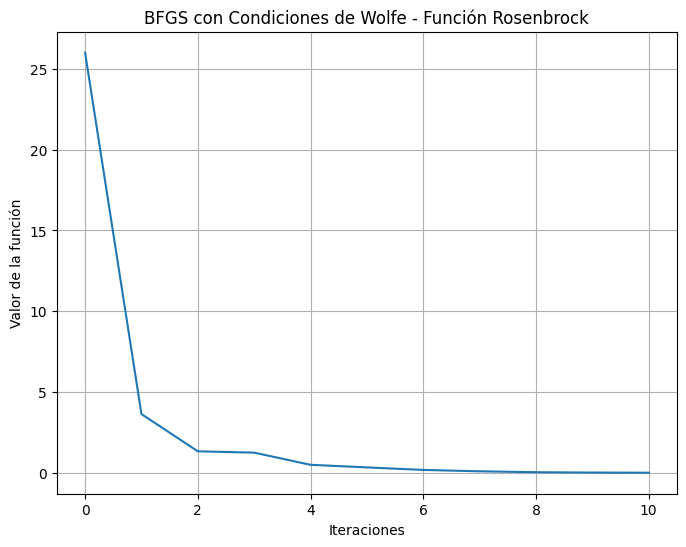

In [42]:
x_rosenbrock, trajectory_rosenbrock = newton_algorithm.optimize(
    func=rosenbrock,
    x0=x0,
    h=1e-5,
    max_iterations=1000,
    stop_value=1e-2
)
x_values.append(x_rosenbrock)
trajectories.append(trajectory_rosenbrock)
function_values.append(rosenbrock(x_rosenbrock))

print("="*60)
print("FUNCIÓN ROSENBROCK")
print("="*60)
print("Valor óptimo encontrado:", x_rosenbrock)
print("Valor de la función en el óptimo:", rosenbrock(x_rosenbrock))
print("Número de iteraciones:", len(trajectory_rosenbrock))
print("\nGráfica Descenso de la función:")
newton_algorithm.plot(trajectory=trajectory_rosenbrock, title="BFGS con Condiciones de Wolfe - Función Rosenbrock")